# SARIMAX model

## Overview

This notebook presents our SARIMAX-based forecasting pipeline, implemented using Nixtla’s **`statsforecast`** library. The model combines a linear regression on carefully engineered exogenous variables (such as temperature, calendar features, and Fourier terms) with a **Seasonal ARIMA** (SARIMA) component that captures residual autocorrelation. The primary goal is to build, tune, and evaluate forecasting models for five previously analyzed time series (F1 to F5), across both **daily** and **weekly** forecast horizons. The entire modeling process is encapsulated within the `SARIMAXPipeline` class.

### Model Specification


Given a target series $y_t$ and a vector of $k$ exogenous regressors $\mathbf{x}_t=(x_{1,t},\dots,x_{k,t})^{\top}$, the SARIMAX model is defined as:


$$
y_t = \beta_0 + \boldsymbol{\beta}^{\!\top} \mathbf{x}_t + \eta_t,\qquad
\eta_t \sim \text{SARIMA}(p,d,q)\times(P,D,Q)_s,
$$

with the SARIMA residual term $\eta_t$ satisfying:

$$
\Phi_P(B^{s})\,\phi_p(B)\,(1-B)^d(1-B^{s})^{D}\,\eta_t
= 
\Theta_Q(B^{s})\,\theta_q(B)\,\varepsilon_t,\qquad
\varepsilon_t \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma^{2}),
$$

where $B$ denotes the backshift operator, $B\eta_t = \eta_{t-1}$. The polynomials are defined as:

* **Non-seasonal AR:** $\phi_p(B) = 1 - \phi_1 B - \dots - \phi_pB^p$
* **Seasonal AR:** $\Phi_P(B^{s}) = 1 - \Phi_1 B^{s} - \dots - \Phi_PB^{Ps}$
* **Non-seasonal MA:** $\theta_q(B) = 1 + \theta_1 B + \dots + \theta_qB^q$
* **Seasonal MA:** $\Theta_Q(B^{s}) = 1 + \Theta_1 B^{s} + \dots + \Theta_QB^{Qs}$

This model captures both short-term dynamics and recurring seasonal patterns. The autoregressive (AR) terms capture the influence of past observations, while the moving average (MA) terms account for past forecast errors. Differencing terms (both seasonal and non-seasonal) help make the series stationary and easier to model.

Nixtla’s implementation estimates model parameters via exact maximum likelihood. Additionally, the API provides an `AutoARIMA` routine that automatically selects optimal $(p,d,q,P,D,Q)$ values by minimizing the corrected Akaike Information Criterion (AICc).

### Why SARIMAX?

SARIMAX was chosen for its balance of interpretability, flexibility, and compatibility with exogenous features. Unlike pure time series models, SARIMAX allows the inclusion of covariates, making it particularly well-suited for structured forecasting tasks where external drivers (e.g., weather) are important.

While the model offers strong performance and transparency, it does have limitations. In particular, feature engineering is manual and critical: the linear regression component cannot automatically extract useful signals from raw features. This stands in contrast to deep learning models, which can often discover non-linear patterns in high-dimensional feature spaces with minimal preprocessing.

### Key Features of Our Implementation

* **Daily seasonality** is captured through the SARIMA residual component, enabling a flexible and adaptive structure for evolving intraday dynamics, unlike fixed-pattern methods such as Fourier series.
* **Weekly seasonality** is explicitly modeled using exogenous Fourier terms, which effectively encode recurring weekly cycles.
* **Long-term (e.g., annual) seasonality** is captured via exogenous temperature variables, which reflect underlying climate-driven trends in the data.

## Import Libreries and Data

Use version 2.2 of Numpy or less for compatibility with Numba.

In [1]:
import sys, numpy, numba
print("Python      :", sys.version.split()[0])
print("NumPy       :", numpy.__version__)
print("Numba       :", numba.__version__)

Python      : 3.12.9
NumPy       : 2.2.6
Numba       : 0.61.2


In [2]:
import subprocess
from pathlib import Path
import importlib.util

# Detect if running on Google Colab
def in_colab():
    return importlib.util.find_spec("google.colab") is not None

# Set base directory and handle environment
if in_colab():
    # Install required packages only if not already installed
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for pkg in ["statsmodels", "statsforecast", "mlforecast"]:
        install(pkg)

    # Mount Google Drive
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')

    # Set base directory to your Drive project folder
    BASE_DIR = Path('/content/drive/MyDrive/heat-forecast')

    # Add `src/` to sys.path for custom package imports
    src_path = BASE_DIR / 'src'
    if str(src_path) not in sys.path:
        sys.path.append(str(src_path))

else:
    # Local/VM setup: assume notebook is in project_root/notebooks/
    BASE_DIR = Path.cwd().parent

In [3]:
# --- Magic Commands ---
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import os
import stat
import sys
import shutil
import warnings
import logging
from datetime import datetime
from functools import reduce
from itertools import product

# --- Logging Configuration ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%H:%M:%S",
    force=True,
    stream=sys.stdout
)

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from mlforecast import MLForecast

# --- Plotting Configuration ---
interactive = False  # Set to False for static plots
plt.style.use("ggplot")
plt.rcParams['font.size'] = 14
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'

# --- YAML Customization ---
def _tuple_representer(dumper, data):
    return dumper.represent_sequence(
        yaml.resolver.BaseResolver.DEFAULT_SEQUENCE_TAG,
        list(data)
    )
yaml.SafeDumper.add_representer(tuple, _tuple_representer)

# --- Safe File Deletion Helper ---
def _on_rm_error(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# --- Project-Specific Imports ---
from heat_forecast.utils.plotting import (
    configure_time_axes, custom_plot_results, scatter_temp_vs_target_hourly
)
from heat_forecast.utils.evaluation import (
    custom_evaluate_cv, display_cv_summary, mae_over_thr_score,
    compute_loss_diff_stats, adj_r2_score, aicc_score, underforecast_over_th_score
)
from heat_forecast.utils.cv_utils import get_cv_params, get_cv_params_for_test
from heat_forecast.pipeline import SARIMAXPipeline, SARIMAXConfig

10:26:35 | INFO | numexpr.utils | NumExpr defaulting to 12 threads.


Import pre-elaborated data.

In [4]:
heat_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'heat.csv'
aux_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'auxiliary.csv'
heat_df = pd.read_csv(heat_path, parse_dates=['ds'])
aux_df = pd.read_csv(aux_path, parse_dates=['ds'])

## Exploring the relationship between temperature and target variable

An important initial step in building the model is identifying potentially informative auxiliary variables. Since temperature exhibits the strongest correlation with the target variable (as seen in `"Series analysis.ipynb"`), we begin by incorporating only this exogenous feature. This analysis will be performed on a per-series basis.

In [5]:
# Choose a single unique_id
id = 'F1'

We plot heat demand against temperature, with each point colored by the corresponding hour of the day. For each hour (i.e., each color), the plot includes two regression lines: one fitted using data from the "winter" period (defined as mid-November to the end of March), and the other using data from the "non-winter" period.

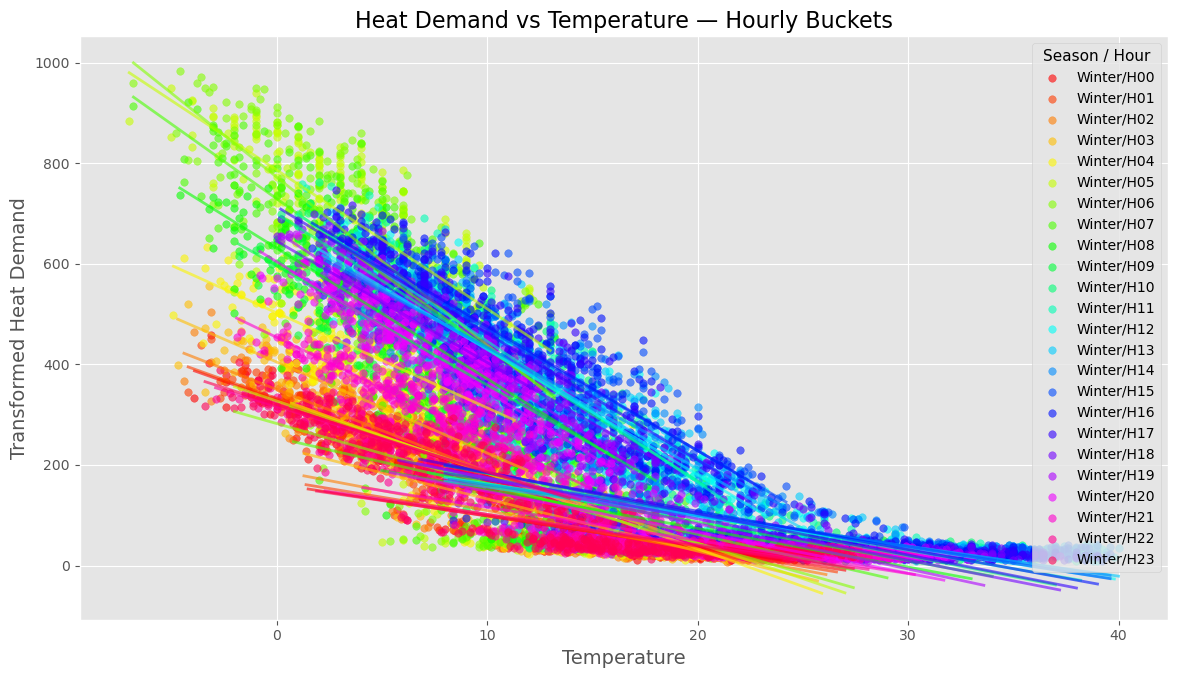

Correlation by season and hour:


Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Season,,,,,,,,,,,,,,,,,,,,,,,,
Non-Winter,-0.77,-0.77,-0.75,-0.74,-0.71,-0.68,-0.69,-0.67,-0.69,-0.71,-0.72,-0.72,-0.71,-0.70,-0.69,-0.69,-0.71,-0.72,-0.72,-0.73,-0.72,-0.74,-0.77,-0.76
Winter,-0.85,-0.85,-0.85,-0.82,-0.79,-0.81,-0.78,-0.78,-0.81,-0.86,-0.89,-0.89,-0.88,-0.87,-0.86,-0.86,-0.89,-0.90,-0.92,-0.92,-0.92,-0.91,-0.85,-0.86


In [6]:
mask = (
    (heat_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (heat_df['unique_id'] == id)
)
heat_train_id_df = heat_df[mask].copy()
mask = (
    (aux_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (aux_df['unique_id'] == id)
)
aux_train_id_df = aux_df[mask].copy()

corr_df = scatter_temp_vs_target_hourly(
    target_df=heat_train_id_df,
    aux_df=aux_train_id_df,
    date_range=pd.date_range(start='2022-05-01', end='2024-05-01', freq='h'),
    interactive=interactive
)

# Display the correlation dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Correlation by season and hour:")
    display(
        corr_df.style
        .background_gradient(cmap='Blues', axis=None, gmap=corr_df.abs(), vmax=1.0, vmin=0.0)  # Add a blue gradient
        .format(precision=2)
        .set_caption("Correlation between Temperature and Heat Demand by Season and Hour")
    )


The figure reveals a distinct difference in the temperature-demand relationship between winter and non-winter, underscoring the importance of explicitly accounting for this seasonal separation. This finding aligns with intuition, given that the target variable reflects heat demand. Additionally, in winter, the slope of the regression line varies noticeably by hour, indicating that daily seasonality is not driven solely by temperature. This again is expected, as human behavior plays a major role in shaping daily heating patterns. However, this complexity in daily seasonality will be addressed later by the SARIMAX residual component, so for now we focus on the winter/non-winter separation only.

A closer analysis of the target variable suggested a more dynamic approach to capturing seasonal separation. Rather than relying on fixed calendar-based "winter" periods, we define the start and end of the cold season based on recent temperature trends. Specifically, a timestamp is classified as part of the "cold semester" if the average temperature over the preceding four days falls below a certain threshold. This threshold is tuned individually for each time series, allowing for a more responsive and data-driven delineation of seasonal behavior.

## Data preparation

The `SARIMAXPipeline.prepare_data` method provides a flexible framework for configuring exogenous variables, making it easy to experiment with and compare different modeling strategies. The supported exogenous inputs fall into two primary categories:

* **Climate-based variables**, sourced from the `aux_df` dataset (e.g., temperature).
* **Seasonal Fourier terms**, used to capture periodic patterns such as daily or weekly seasonality.

The table below summarizes all available options for preparing these exogenous features, which constitute the majority of parameters within the `SARIMAXConfig`.

> **Basic Configuration**
>
> * **`with_exog`**: Toggles the inclusion of exogenous (i.e. climate-based) variables.
> * **`exog_vars`**: List of column names from `aux_df` to use as exogenous inputs (e.g., `['temperature', 'dew_point']`). If `with_exog=True`, `temperature` **must** be included, as it is used to distinguish
between cold and warm seasonal regimes.
>
>**Transformations of Temperature**
>
>* **`temp_transform`**: Enables a piecewise-sigmoid transformation for temperature.
>* **`threshold`, `lower_asymptote`, `upper_asymptote`, `k`, `k_right`**: Parameters for the piecewise-sigmoid function, used to model saturation or diminishing returns in temperature effects.
>
>**Cold vs. Non-Cold Period Handling**
>
>* **Automatic cold period detection**: A point is labeled “cold” if the 4-day moving average temperature falls below the defined `threshold`.
>* **`is_cold`**: A derived binary indicator used to distinguish cold and non-cold periods.
>* **`k_week_only_when_cold`**: If `True`, weekly Fourier terms are only applied during cold periods, based on the `is_cold` flag.
>
>**Fourier-Based Seasonality**
>
>* **`k_week`**: Number of Fourier terms for modeling **weekly** seasonality (168-hour cycles).
>* **`k_day`**: Number of Fourier terms for modeling **daily** seasonality (24-hour cycles) (typically, we set `k_day = 0` and allow the SARIMA residuals to capture daily seasonal effects).
>
>**Lagged and Aggregated Features**
>
>* **`drop_hourly_exog`**: If `True`, raw hourly features are discarded after generating lagged or aggregated versions.
>* **`lags_exog`**: List of lag offsets (e.g., `[1, 24, 48]`) to include past values of selected exogenous variables. Ignored if `drop_hourly_exog=True`.
>* **`days_averages` / `max_lag_daily_agg`**: Computes multi-day rolling averages with optional lags (e.g., 3-day mean temperature).
>* **`hours_averages` / `max_lag_hourly_agg`**: Similar to above but over shorter hourly windows (e.g., 6-hour average).
>
>**Peak Hour Splits**
>
>* **`use_is_peak`**: If enabled, both climate-based and high-frequency features are split into `*_peak` and `*_offpeak` variants based on defined peak hours.
>* **`peak_hours`**: List of hours considered peak demand times (e.g., `[6, 7]`). Defaults to per-series selections if not specified.
>
>**Cold/Warm Feature Duplication**
>
>* When `with_exog = True`, all exogenous variables and Fourier terms are duplicated into `*_cold` and `*_warm` versions based on the `is_cold` label.
>This setup allows the model to learn season-specific effects, enabling distinct feature sets for cold and warm periods.
>* **`drop_warm`**: If set to `True`, all climate-related columns relative to the warm season are dropped, except for the 1-day rolling average of temperature (if this feature is enabled). This option is useful for simplifying the model, as heat demand tends to remain relatively flat during the warm season, making forecasting during this period less relevant.


The `piecewise_sigmoid` function for temperature transformation models a smooth, S-shaped curve that transitions from a lower bound to an upper bound, centered at a midpoint. Although we ultimately chose not to use it, it is briefly described here for completeness. It consists of two logistic curves joined at the midpoint `mid`, and is continuous (and optionally smooth in its first derivative) at that point.

Precisely:
$$
f(x) =
\begin{cases}
\ell + \dfrac{2(m - \ell)}{1 + e^{-k_L(x - m)}} & \text{if } x \leq m \\
u - \dfrac{2(u - m)}{1 + e^{k_R(x - m)}} & \text{if } x > m
\end{cases}
$$

where:
- $ \ell $ is the `lower_asymptote`;
- $ u $ is the `upper_asymptote`;
- $ m $ is the midpoint `mid`;
- $ k_L $ is `k_left` and controls the slope of the left sigmoid;
- $ k_R $ is `k_right` and controls the slope of the right sigmoid (optional). 

If `k_right` is not specified, it defaults to:
$$
k_R = k_L \cdot \frac{m - \ell}{u - m},
$$
ensuring the first derivative is continuous at $x = m$. 

$k_L$ and $k_R$ can be interpreted as steepness factors as:
$$
f'(m^-) = \frac{(m - \ell) \cdot k_L}{2},  \quad f'(m^-) = \frac{(m - \ell) \cdot k_L}{2} 
$$

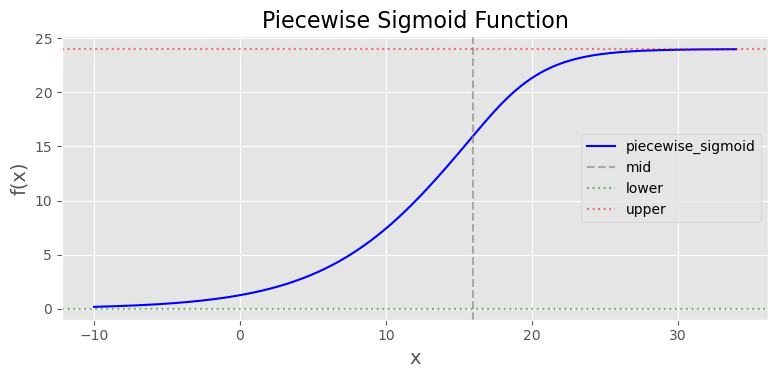

In [7]:
def piecewise_sigmoid(x, mid, lower, upper, k_left=0.5, k_right=None):
    if not (lower < mid < upper):
        raise ValueError("Must satisfy: lower < mid < upper")
    
    x = np.asarray(x)

    if k_right is None:
        k_right = k_left * (mid - lower) / (upper - mid)

    left_piece = lower + 2*(mid - lower) / (1 + np.exp(-k_left * (x - mid)))
    right_piece = upper - 2*(upper - mid) / (1 + np.exp(k_right * (x - mid)))
    
    result = np.where(x <= mid, left_piece, right_piece)
    return result.item() if result.ndim == 0 else result


# --- Visualization ---
def plot_piecewise_sigmoid(mid=16, lower=0, upper=24, k_left=0.2, k_right=None):
    x_vals = np.linspace(lower - 10, upper + 10, 500)
    y_vals = piecewise_sigmoid(x_vals, mid=mid, lower=lower, upper=upper, k_left=k_left, k_right=k_right)

    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, y_vals, label='piecewise_sigmoid', color='blue')
    plt.axvline(mid, color='gray', linestyle='--', alpha=0.6, label='mid')
    plt.axhline(lower, color='green', linestyle=':', alpha=0.5, label='lower')
    plt.axhline(upper, color='red', linestyle=':', alpha=0.5, label='upper')
    plt.title("Piecewise Sigmoid Function")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Try the default parameters ---
plot_piecewise_sigmoid()


The `SARIMAXPipeline.prepare_data` method also supports transforming the target variable (`y`). This can help stabilize variance and improve model performance.

> **Target Transformation Options**
>
> * **`transform`**: Specifies the transformation applied to the target variable. Options include:
>   - `"none"` or `None`: No transformation.
>   - `"log"` or `"arcsinh"`: Standard transformations for stabilizing variance.
>   - `"boxcox"`: Applies the Box-Cox transformation with λ estimated from the full training target series.
>   - `"boxcox_winter"`: Box-Cox transformation with λ estimated only from winter periods (typically mid-November to March).
>   - `"boxcox_cold"`: Box-Cox transformation with λ estimated from observations labeled as cold (`is_cold=True`).
>
> * **`lam_method`**: Specifies the method for estimating the Box-Cox λ parameter. Options:
>   - `"loglik"`: Maximum likelihood estimation.
>   - `"guerrero"`: Minimizes the coefficient of variation across groups.
>
> * **`is_winter`**: Optional custom function for defining "winter" periods used in the `boxcox_winter` setting.

## Fine tuning

### Choosing an appropriate threshold

A first, crucial parameter to choose is the `threshold` parameter (for seasonal separation, explained above). To choose it, we perform a simple linear regression, regressing the target variable with the temperature with cold/warm seasonal separation (i.e., only three variables: `temperature_cold`, `temperature_warm` and the binary `is_cold`), and see which threshold works best.

To evaluate the model's goodness of fit, we use four key metrics:

- **Adjusted $R^2$**: Measures the proportion of variance explained by the model, adjusted for the number of predictors (of course, at this stage we could avoid correcting for model complexity).

- **AICc (Corrected Akaike Information Criterion)**: A likelihood-based metric that balances model fit and complexity. The corrected version (AICc) is particularly useful for small sample sizes, helping to prevent overfitting by penalizing excessive parameters.

- **MAE "at-peak"**: Mean Absolute Error computed only on high-demand period; specifically, when heat demand exceeds 100 kWh. This focuses the evaluation on the most critical periods for forecasting accuracy.

- **Underfit Score**: Defined as the positive part of the Mean Error during peak periods $\max(0, y_t - \hat{y}_t)$. This metric highlights instances where the model significantly underestimates demand, helping to monitor underfitting in high-demand scenarios.

In [8]:
# Pick an id and a candidate threshold 
id = 'F1'
threshold = 13.5 # Example threshold

# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(
    with_exog=True,
    exog_vars=['temperature'],
    threshold=threshold,  
    days_averages=None,
    transform='none'
)

# Create the SARIMAX pipeline with the specified configuration and generate the data
mask = (
    (heat_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (heat_df['unique_id'] == id)
)
heat_train_id_df = heat_df[mask].copy()
mask = (
    (aux_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (aux_df['unique_id'] == id)
)
aux_train_id_df = aux_df[mask].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_train_id_df,
    aux_df=aux_train_id_df,
    config=sconfig,
)
spipeline.prepare_data()
prepared_data = spipeline.prepared_data

spipeline.describe_prepared_data()
    

10:28:45 | INFO | heat_forecast.pipeline.sarimax | Prepared data description:
Unique id: F1
Using target transform: none
Using a temperature transform?: false
data:
    shape: (43128, 6)
    columns:
        basic:
        - unique_id
        - ds
        - y
        climate-based:
        - temperature_cold
        - temperature_warm
        - is_cold
        fourier: []
    start_date: '2019-07-01 00:00:00'
    end_date: '2024-05-31 23:00:00'



10:28:47 | INFO | root | Results for threshold 13.5 and unique_id F1:
10:28:47 | INFO | root | > Adjusted R^2 score  : 0.792
10:28:47 | INFO | root | > AICc score          : 396857.695
10:28:47 | INFO | root | > MAE at-peak score   : 69.720
10:28:47 | INFO | root | > Underfit score      : 76.517


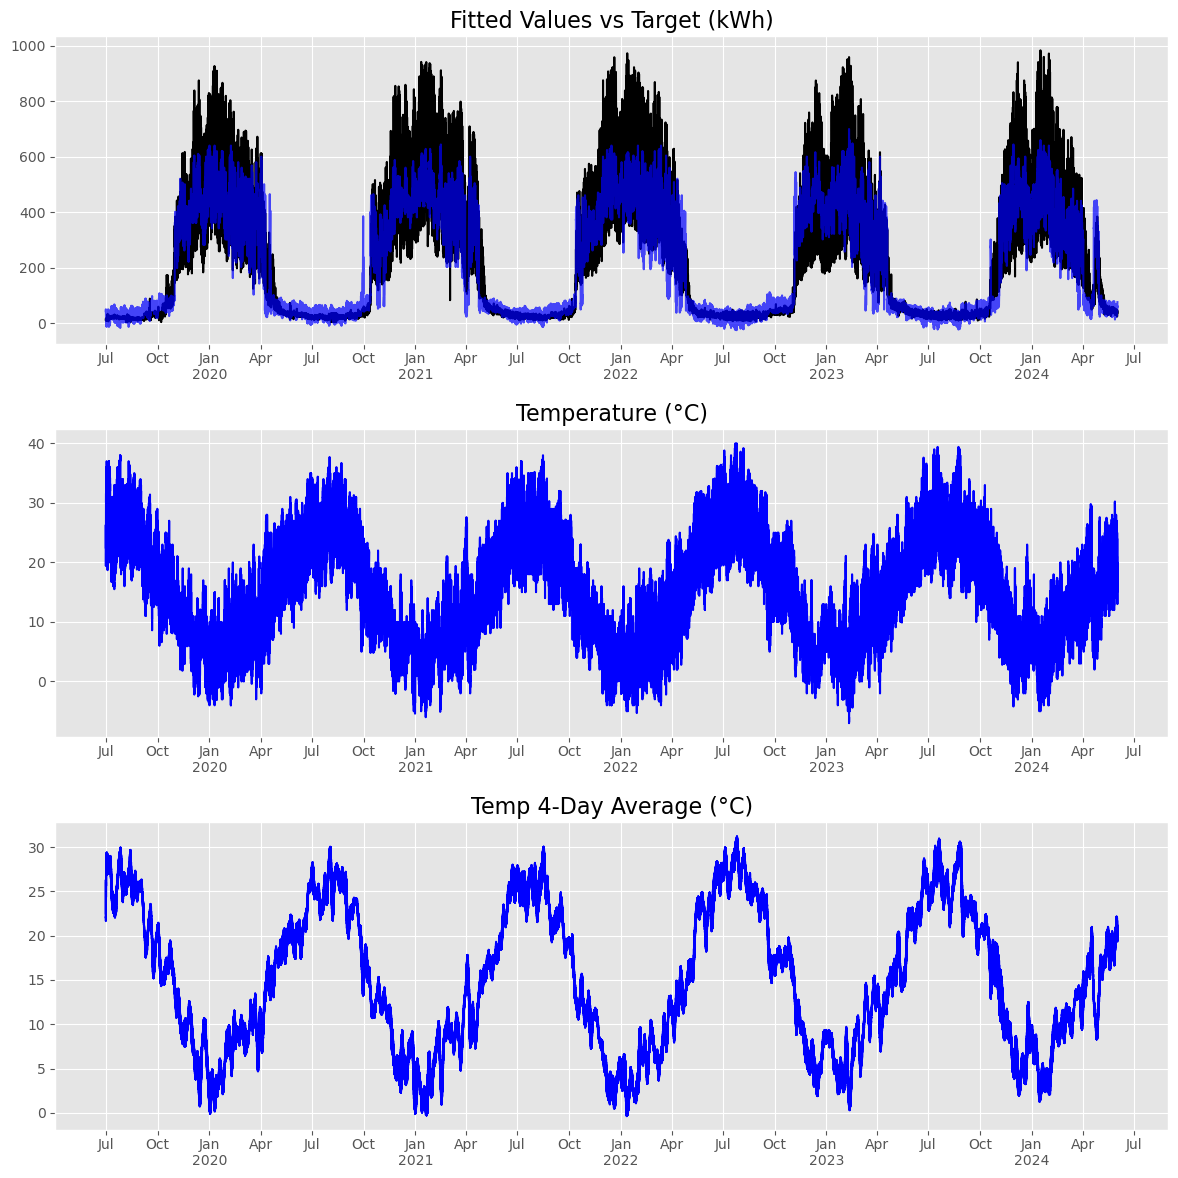

In [9]:
# Do you want to overlay warm data as red vertical lines?
highlight_warm_data = False

# Fit model
mf = MLForecast(models=LinearRegression(), freq="h")
mf.fit(prepared_data, fitted=True, static_features=[])

# Get fitted values and calculate evaluation metrics
fitted_values = mf.forecast_fitted_values()
insample_forecasts = fitted_values['LinearRegression']
insample_y = prepared_data['y']

T = len(insample_y)
K_par = len(mf.models_["LinearRegression"].coef_) # Number of parameters in the linear model

logging.info(f"Results for threshold {threshold} and unique_id {id}:")
logging.info(f"> Adjusted R^2 score  : {adj_r2_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> AICc score          : {aicc_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> MAE at-peak score   : {mae_over_thr_score(insample_y, insample_forecasts, y_th=17):.3f}")
logging.info(f"> Underfit score      : {underforecast_over_th_score(insample_y, insample_forecasts, y_th=17):.3f}")

# plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()

axes[0].plot(prepared_data['ds'], insample_y, label='Transformed Target', color='black', alpha=1.0)
axes[0].plot(fitted_values['ds'], insample_forecasts, label='Fitted Values', color='blue', alpha=0.7)
axes[0].set_title('Fitted Values vs Target (kWh)')

filtered_aux_train_df = aux_df.loc[
    aux_df['ds'].isin(prepared_data['ds']), 
    ['ds', 'unique_id', 'temperature']
]
filtered_aux_train_df.sort_values(by='ds', inplace=True)

axes[1].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temperature'], label='Temperature', color='blue', alpha=1.)
axes[1].set_title('Temperature (°C)')

filtered_aux_train_df['temp_fewdays_avg'] = (
    filtered_aux_train_df
    .groupby('unique_id')['temperature']
    .rolling(window=24*4, min_periods=1)  
    .mean()
    .reset_index(0, drop=True)
)

axes[2].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temp_fewdays_avg'], label='Temp 4-Day Avg', color='blue', alpha=1.)
axes[2].set_title('Temp 4-Day Average (°C)')

# Overlay missing timestamps as red vertical lines
if highlight_warm_data:
    cold_df = prepared_data[prepared_data['is_cold'] == 1].copy()
    all = pd.date_range(start=prepared_data['ds'].min(), end=prepared_data['ds'].max(), freq='h')
    actual = pd.Series(1, index=cold_df['ds'])
    missing = all.difference(actual.index)
    axes[0].vlines(
        x=missing,
        ymin=cold_df['y'].min(),  
        ymax=cold_df['y'].max(), 
        color='red',
        linestyle='--',
        alpha=0.5,
        linewidth=0.5
    )

configure_time_axes(axes, prepared_data['ds'])

fig.tight_layout()

In [10]:
best_thresholds = {
    'F1': 13.5,
    'F2': 13.8,
    'F3': 13.8,
    'F4': 12.8,
    'F5': 13.8,
}

### Choosing temperature and target transformations

After selecting an appropriate threshold, the second step involves choosing suitable transformations for both the target and the temperature variables. We adopt the following strategy:

- **No transformation of temperature**: We opt to use raw temperature values, as the time series do not show evidence of saturation effects on the cold side (i.e., there is no visible plateau in heat demand at very low temperatures). Additionally, potential saturation effects on the warm side are already accounted for by the seasonal (cold/warm) separation in the modeling pipeline.

- **Box-Cox transformation of the target variable with option `boxcold_cold`**: This transformation is applied to the target variable specifically during the 'cold' period to stabilize its variance and reduce oscillations. This is particularly important because the Fourier terms used to model seasonality are also split by cold and warm seasons, and we want to enhance their ability to capture consistent seasonal patterns during colder periods.

### Choosing climate-based features and SARIMA parameters

Performing an exhaustive grid search over SARIMA parameters is impractical due to prohibitively long training times. Instead, we adopt a more efficient, staged approach:

- **Step 1: Initial Model Selection**  
  Begin by fixing a promising SARIMA structure for the residuals based on early experimentation. In our case, preliminary tests consistently pointed to:  
  $$
  \text{SARIMA}(p,d,q)\times(P,D,Q)_{s} = \text{SARIMA}(1,0,0)\times(1,1,1)_{24}
  $$  
  This structure was identified by first selecting simple but reasonable auxiliary regression variables, fitting a linear model, and analyzing the ACF and PACF plots of the residuals. These plots suggested a similar model, differing only by $Q = 0$. Subsequent cross-validation with minimal parameter adjustments confirmed the above configuration as a robust starting point. Additionally, running `AutoARIMA` on series F1 (with conservative starting values) repeatedly returned either the same model or slight variations, further supporting this selection.

- **Step 2: Targeted Cross-Validation**  
  Perform cross-validation over a limited set of SARIMA parameter combinations, gradually increasing model complexity to identify the best-performing configuration.

- **Step 3 (Optional): AutoARIMA Refinement**  
  Optionally, apply an AutoARIMA procedure initialized with the best parameters from Step 2 to explore nearby configurations. If improvements are found, repeat the cross-validation process.

- **Step 4 (Optional): Expand Exogenous Variables**  
  Optionally, repeat the entire process using additional exogenous variables beyond temperature to assess potential gains in predictive performance.

In practice, however, neither Step 3 nor Step 4 led to significant improvements in our results.

In [72]:
finetune = False  # Set to False to skip fine-tuning

 # Forecast horizon in hours (1 week). We only use this forecast horizon for fine-tuning
            # because it allows as to consider less windows and since we are testing a very limited set of parameters
            # in which we study the effectiveness of different variables in explaining the target,
            # we don't expect to get meaningfully different results with shorter horizons

# Note: by default we have:
# - `tranform`='boxcox_cold';
# - `lam_method`='loglik';
# - `k_week_only_when_cold`=True;

all_params = [
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 4,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': True,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Basic parameters, should work well for all facilities
        'k_week': 4,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # More Fourier terms
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False,
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Added 7-day averages, 1 lag of temperature, separation using peak hours
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # More lags of tempearture
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # More fourier terms, heaviest configuration
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    }
]

if finetune:
    # ------------- Choose parameters for cross-validation -------------
    # For get_cv_params:
    n_windows = 15  
    h = 168  # Forecast horizon in hours (1 week)
    start_test_cv = pd.to_datetime('2023-11-15')
    end_test_cv = pd.to_datetime('2024-04-01')
    # For fitting furing cross-validation:
    input_size = 365*24  # Number of hours to consider for each training

    metadata = {f'params_set_{i}': all_params[i] for i in range(len(all_params))}
    metadata['for_get_cv_params'] = {
        'n_windows': n_windows,
        'forecast_horizon': h,
        'start_test_cv': str(start_test_cv),
        'end_test_cv': str(end_test_cv),
    }
    metadata['input_size'] = input_size

    # ------------- Create directory for fine-tuning results -------------
    timestamp = datetime.now().strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_finetuning_sarimax_{timestamp}"
    path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
    metadata['run_id'] = run_id

    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for fine-tuning results: {path.relative_to(BASE_DIR)}")

        # ------------- Set windows with get_cv_params -------------  
        step_size, test_hours, end_test_cv = get_cv_params(
            start_test_cv=start_test_cv,  
            end_test_cv=end_test_cv,    
            n_windows=n_windows,  
            horizon_hours=h,  
        )

        # ------------- Run CV once with the naive model for comparison -------------
        naive_model = SeasonalNaive(season_length=24, alias='Naive24h')
        sf = StatsForecast(models=[naive_model], freq='h')
        heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
        full_df = heat_id_df[heat_id_df['ds'] <= end_test_cv]  # Use all data up to the end of the last forecast horizon
        t0 = pd.Timestamp.now()
        cv_naive = sf.cross_validation(
            h=h,
            df=full_df,
            n_windows=n_windows,
            step_size=step_size,  
            test_size=test_hours,  
            input_size=None,  
            refit=True,  
        )
        t1 = pd.Timestamp.now()
        elapsed = (t1 - t0).total_seconds()
        params_placeholder = {key: None for key in all_params[0].keys()}
        params_except_sarima = {k:v for k,v in params_placeholder.items() if k != 'sarima_kwargs'}
        record = {
            'name': 'Naive24h',
            'avg_elapsed_sec': elapsed/n_windows,  
            **params_except_sarima,  # Don't need to retain the SARIMA parameters for records
        }

        # store results and corresponding params / name of the model / elapsed time
        records = [record]  
        cv_frames = [cv_naive]

        # ------------- Run grid search for MSTL model -------------
        aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
        t_start_cv = pd.Timestamp.now()
        for i, params in enumerate(tqdm(all_params, desc="Grid search", leave=True)):

            sconfig = SARIMAXConfig(**params)
            spipeline = SARIMAXPipeline(
                target_df=heat_id_df,
                aux_df=aux_id_df,
                config=sconfig,
            )
            t0 = pd.Timestamp.now()
            cv_sarimax = spipeline.cross_validation(
                h=h,                   # Forecast horizon in hours
                test_size=test_hours,  # Test size in hours
                end_test=end_test_cv,  # End of the test period
                step_size=step_size,   # Step size in hours
                input_size=input_size,     # Number of hours to consider for each training
                verbose=False,
                alias=f'SARIMAX_{i}',  # Alias for the model
            )
            t1 = pd.Timestamp.now()
            elapsed = (t1 - t0).total_seconds()
            cv_sarimax.drop(columns=['y'], inplace=True)
            cv_frames.append(cv_sarimax)

            params_except_sarima = {k:v for k,v in params.items() if k != 'sarima_kwargs'}
            record = {
                'name': f'SARIMAX_{i}',  
                'avg_elapsed_sec': elapsed/n_windows,
                **params_except_sarima,  
            }
            records.append(record)

        # ------------- Combine all cross-validation results into a single DataFrame -------------
        key_cols = ["unique_id", "ds", "cutoff"]
        cv_results_df = reduce(
            lambda left, right: pd.merge(left, right, on=key_cols, how="outer"),
            cv_frames            
        )
        records_df = pd.DataFrame(records)
        results = (records_df, cv_results_df)

        t_end_cv = pd.Timestamp.now()
        elapsed_cv = str(t_end_cv - t_start_cv)
        metadata['total_elapsed_time'] = elapsed_cv

        # ------------- Final save -------------
        records_df.to_parquet(path / "records.parquet", compression="snappy")
        cv_results_df.to_parquet(path / "cv_results.parquet", compression="snappy")

        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            yaml.safe_dump(
                metadata,
                f,
                indent=4,                    # indentation for nested structures
                default_flow_style=False,    # block style
                sort_keys=False              # preserve insertion order
            )

        logging.info("✓ All artifacts saved successfully, fine-tuning completed.")

    except KeyboardInterrupt:
        logging.warning("✗ Fine-tuning interrupted by user, cleaning up.")
        shutil.rmtree(path, onexc=_on_rm_error)
        logging.info("✓ Removed directory %s after interrupt", path.relative_to(BASE_DIR))
        raise

    except Exception:
        logging.exception("✗ Error during fine-tuning save, cleaning up.")
        shutil.rmtree(path, onexc=_on_rm_error)
        logging.info("✓ Removed directory %s", path)
        raise

In [73]:
# Optional: pick a run_id to analyze 
run_id = 'F1_finetuning_sarimax_20250719T083036'  

# ----------------- Load the metadata for the run_id -------------
path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
records_df = pd.read_parquet(path / "records.parquet")
cv_results_df = pd.read_parquet(path / "cv_results.parquet")

# --------------- Evaluate results -------------
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="DataFrame is highly fragmented",
        category=pd.errors.PerformanceWarning,
    )
    summary, combined_results = custom_evaluate_cv(
        cv_df=cv_results_df,
        metrics=['mae', 'rmse', 'mase', 'nmae'],  # List of metrics to compute
        target_df=heat_df,  
    )
    summary_ld, combined_ld = compute_loss_diff_stats(combined_results)

In [74]:
# --------------- Display with optional sorting -------------
wide_summary = display_cv_summary(
    summary,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [75]:
# --------------- Display with optional sorting -------------
wide_summary_ld = display_cv_summary(
    summary_ld,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [76]:
# --------------- Display the records of the first n models (based on the previous sorting) -------------
n = 50     # how many?  

# Select the first n models based on the sorted summary snd the corresponding records
s = wide_summary.reset_index()    
models_chosen = s.iloc[:n, s.columns.get_loc("model")].to_numpy().reshape(-1).tolist()
model_order = {model: i for i, model in enumerate(models_chosen)}
filtered_df = records_df.loc[records_df['name'].isin(models_chosen), :].copy()
filtered_df['order'] = filtered_df['name'].map(model_order)
ordered_df = filtered_df.sort_values('order').drop('order', axis=1).reset_index(drop=True)

# Display the ordered DataFrame with all rows and columns
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ordered_df)

,name,avg_elapsed_sec,k_week,threshold,days_averages,drop_hourly_exog,lags_exog,use_peak_hours
0,SARIMAX_5,75.896,7.000,13.500,"[1, 4]",False,"[1, 2, 3]",True
1,SARIMAX_3,57.414,5.000,13.500,"[1, 4]",False,[1],True
2,SARIMAX_4,66.433,5.000,13.500,"[1, 4]",False,"[1, 2, 3]",True
3,SARIMAX_2,55.357,7.000,13.500,[1],False,None,False
4,SARIMAX_1,41.991,4.000,13.500,[1],False,None,False
5,SARIMAX_0,37.673,4.000,13.500,[1],True,None,False
6,Naive24h,0.001,NaN,NaN,None,None,None,None


### Final optimal parameters

Observations:
* **F1**: The performance of models `SARIMAX_2` through `SARIMAX_5` is largely comparable. The lack of improvement from `SARIMAX_3` to `SARIMAX_4` suggests that adding additional lags of the temperature variable does not significantly enhance performance. In contrast, increasing the number of Fourier terms appears beneficial. Based on this, we retain the configuration of `SARIMAX_3` but increase the number of weekly Fourier terms (`k_week`) from 5 to 7.

* **F2**: There is minimal performance improvement beyond `SARIMAX_3`, indicating that additional complexity offers little benefit. We therefore retain the configuration of `SARIMAX_3`.

* **F3**: Both `SARIMAX_3` and `SARIMAX_5` slightly outperform the other variants. We select `SARIMAX_3`, enhanced with additional Fourier terms, as it shows a modest reduction in the standard deviation of the loss difference relative to the naive baseline.

* **F4**: All models except `SARIMAX_0` perform similarly. We retain `SARIMAX_3` as it appears to be the most robust choice, having been selected frequently. However, `SARIMAX_1` may be a viable alternative for faster training (approximately 24 seconds vs. 33 seconds per fit), with only a negligible drop in accuracy.

* **F5**: The results again favor `SARIMAX_3` with an increased number of Fourier terms. Given the more noticeable performance gain between `SARIMAX_4` and `SARIMAX_5`, we test a larger seasonal component by increasing `k_week` to 9 (instead of 7) to better capture underlying patterns.

In [11]:
save = False  # Set to False to skip saving the parameters

sarimax_optimal_params = {
    'F1': { # SARIMAX_3 with more fourier terms
        'k_week': 7,
        'threshold': best_thresholds['F1'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
    },
    'F2': { # SARIMAX_3
        'k_week': 5,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F3': { # SARIMAX_3 with more fourier terms
        'k_week': 7,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F4': { # SARIMAX_3
        'k_week': 5,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F5': { # SARIMAX_3 with more fourier terms
        'k_week': 9,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
}

if save:
    params_path = BASE_DIR / "models" / "sarimax_optimal_params.yaml"
    with open(params_path, 'w') as f:
        yaml.safe_dump(
            sarimax_optimal_params,
            f,
            indent=4,                    # indentation for nested structures
            default_flow_style=False,    # block style
            sort_keys=False              # preserve insertion order
        )
    logging.info("✓ Optimal parameters saved successfully.")

## Testing

Final model testing is conducted using a cross-validation procedure focused on the cold season of 2024–2025. For the **weekly forecast horizon**, approximately **20 test windows** are used, while the **daily horizon** utilizes around **35 windows**. The number of windows for the weekly horizon is deliberately limited to minimize correlation between adjacent test periods.

The exact number of windows, as well as the start and end dates of the test period, may vary slightly between time series. In each case, the test range and number of windows are chosen to:

* start when heat demand begins to rise after the summer period and end as demand declines with the return of warmer weather;
* use a step size of 9 for weekly forecasts and 5 for daily forecasts.

In [78]:
do_test = False  # Set to False to skip test

if do_test:
    grid = list(product(['F1', 'F2', 'F3', 'F4', 'F5'], ['week', 'day']))
    for id, horizon_type in tqdm(grid, desc="Test", leave=True):

        metadata = {}

        # ------------- Create directory for test results -------------
        timestamp = datetime.now().strftime("%Y%m%dT%H%M%S")
        run_id = f"{id}_{horizon_type}_test_sarimax_{timestamp}"
        path = BASE_DIR / "results" / "test" / "sarimax" / run_id
        metadata['run_id'] = run_id

        try:
            path.mkdir(parents=True, exist_ok=False)
            logging.info(f"Created directory for test results: {path.relative_to(BASE_DIR)}")


            # ------------- Set params for cv -------------
            step_size, test_hours, end_test_cv = get_cv_params_for_test(id, horizon_type)
            input_size = 365*24  
            metadata['for_cv'] = {
                'step_size': step_size,
                'test_hours': test_hours,
                'end_test_cv': str(end_test_cv),
                'input_size': input_size,
            }
            h = 24*7 if horizon_type == 'week' else 24  

            # ------------- Run cross-validation with the optimal parameters -------------
            optimal_params = sarimax_optimal_params[id]
            metadata['optimal_params'] = optimal_params
            sconfig = SARIMAXConfig(**optimal_params)

            heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
            aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
            spipeline = SARIMAXPipeline(
                target_df=heat_id_df,
                aux_df=aux_id_df,
                config=sconfig,
            )

            t0 = pd.Timestamp.now()
            cv_df = spipeline.cross_validation(
                h=h, 
                test_size=test_hours,  # Test size in hours
                end_test=end_test_cv,  # End of the test period
                step_size=step_size,   # Step size in hours
                input_size=input_size, # Number of hours to consider for each training
                verbose=True,
            )
            t1 = pd.Timestamp.now()

            avg_elapsed = (t1 - t0).total_seconds() / n_windows
            metadata['avg_elapsed_sec'] = avg_elapsed

            cv_df.to_parquet(path / "cv_df.parquet", compression="snappy")

            metadata_path = path / 'metadata.yaml'
            with open(metadata_path, 'w') as f:
                yaml.safe_dump(
                    metadata,
                    f,
                    default_flow_style=False,    # block style
                    sort_keys=False              # preserve insertion order
                )

            logging.info(f"✓ Artifacts saved successfully for id={id}, horizon={horizon_type}.")

        except KeyboardInterrupt:
            logging.warning("✗ Fine-tuning interrupted by user, cleaning up.")
            shutil.rmtree(path, onexc=_on_rm_error)
            logging.info("✓ Removed directory %s after interrupt", path.relative_to(BASE_DIR))
            raise

        except Exception:
            logging.exception(f"✗ Error during test for id={id}, horizon={horizon_type}, cleaning up.")
            shutil.rmtree(path, onexc=_on_rm_error)
            logging.info("✓ Removed directory %s", path)
            raise

    logging.info(f"✓ Test completed.")


## Eample of fit and forecast

For completeness, here is an example of a simple fit + forecast with the SARIMAX custom pipeline.

20:21:46 | INFO | heat_forecast.pipeline.sarimax | Fitting SARIMAX model: start_train=2023-01-06 23:00:00, end_train=2024-01-06 23:00:00
20:22:36 | INFO | heat_forecast.pipeline.sarimax | ✓ SARIMAX model fitted successfully.


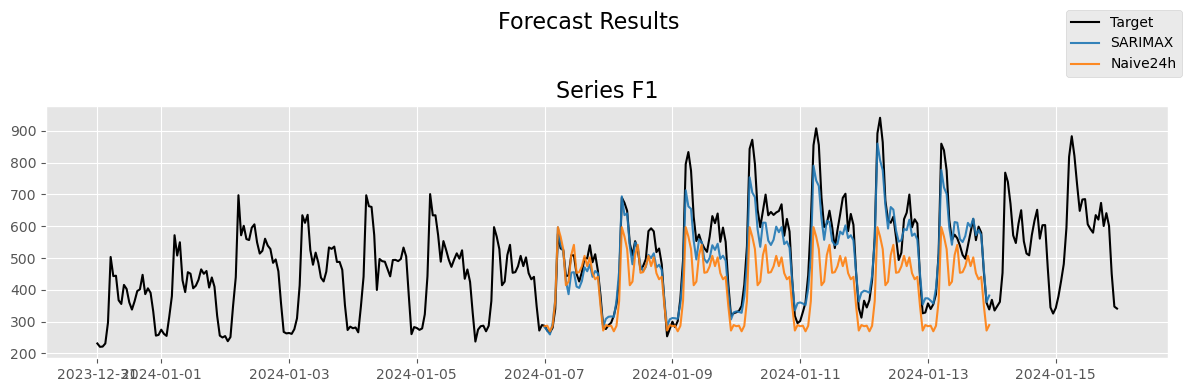

In [79]:
# Pick an id and a candidate threshold 
id = 'F1'

# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(**sarimax_optimal_params[id])

# Create the SARIMAX pipeline with the specified configuration and generate the data
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_id_df,
    config=sconfig,
    aux_df=aux_id_df,
)
spipeline.prepare_data()

# Fit the SARIMAX model
start_train = pd.Timestamp('2023-01-06 23:00:00')
end_train = pd.Timestamp('2024-01-06 23:00:00')
spipeline.fit(
    start_train=start_train,
    end_train=end_train,
)

# Generate forecasts and plot the results
forecasts = spipeline.predict(h=24*7)
custom_plot_results(
    target_df=heat_id_df,
    forecast_df=forecasts,
    start_offset=24*7,
    end_offset=24*2,
    with_naive=True,
    target_train_df=heat_id_df[heat_id_df['ds'] <= end_train],
)